# Recognizing Ricochet Robots [WIP]

Given an image of a
[Ricochet Robots](https://en.wikipedia.org/wiki/Ricochet_Robots) board, I was
trying to parse the board into an appropriate data structure (for manipulation
and solving purposes).

I was able to:

- Threshold the board from its surroundings and generate its convex hull
- Bound the board by a (reasonable) quadrilateral
- Un-warp the quadrilateral into a square (as if one was looking straight down
  at a board with no margins at the edges)
- Segment the board into cells
- Classify cells containing colored robots (hacky; using hard-coded masks)
- Make some progress on segmentation and classification of cell boundaries (by
  extracting sample images of all 8 intersection types and comparing cell
  intersections to these samples using various similarity and template matching
  techniques)

Unfortunately, I ran into a bit of a wall at that point using traditional
computer vision techniques. I think there is still progress to be made without
resorting to modern image models (for segmentation and classification of board
cells), but either way, I would likely have to compile a decent-sized corpus of
real-life board images as my next step.

To be revisited...


In [1]:
# ! pip install opencv-python numpy sympy scikit-image imagehash pillow

In [2]:
from collections import defaultdict

import cv2
import imagehash
import numpy as np
import sympy

from PIL import Image
from skimage.metrics import structural_similarity

cv = cv2
import matplotlib.pyplot as plt

In [3]:
def plot(cv_image):
    plt.imshow(cv2.cvtColor(cv_image, cv2.COLOR_BGR2RGB))
    plt.show()

In [4]:
def largest_contour(contours):
    max_index = None
    max_area = float("-inf")
    for i, contour in enumerate(contours):
        area = cv2.contourArea(contour)
        if area > max_area:
            max_index = i
            max_area = area
    return (max_index, max_area)


# Adapted from https://stackoverflow.com/questions/41138000/fit-quadrilateral-tetragon-to-a-blob/74620309.
def expand_convex_hull_to_ngon(hull, n) -> list[(int, int)]:
    original = hull
    hull = [sympy.Point(*point) for point in hull]

    # Run until we cut down to N vertices:
    while len(hull) > n:
        # Find smallest edge:
        min_edge_idxs, min_length = None, float("inf")
        for edge_start_idx in range(len(hull)):
            edge_end_idx = (edge_start_idx + 1) % len(hull)
            edge_start = sympy.Point(*hull[edge_start_idx])
            edge_end = sympy.Point(*hull[edge_end_idx])
            length = sympy.Segment(edge_start, edge_end).length
            if length < min_length:
                min_edge_idxs = (edge_start_idx, edge_end_idx)
                min_length = length

        prev_start_idx = (min_edge_idxs[0] - 1) % len(hull)
        next_end_idx = (min_edge_idxs[1] + 1) % len(hull)

        prev_start = sympy.Point(*hull[prev_start_idx])
        edge_start = sympy.Point(*hull[min_edge_idxs[0]])
        edge_end = sympy.Point(*hull[min_edge_idxs[1]])
        next_end = sympy.Point(*hull[next_end_idx])

        # Find previous edge and next edge; compute their intersection point.
        prev_edge = sympy.Line(prev_start, edge_start)
        next_edge = sympy.Line(edge_end, next_end)
        intersection = prev_edge.intersection(next_edge)[0]

        # Replace the two smallest edge points with the intersection point.
        hull[min_edge_idxs[0]] = intersection
        del hull[min_edge_idxs[1]]

    hull = np.array([(int(x), int(y)) for x, y in hull])
    return hull


def get_bounding_quadrilateral(board, do_plot=False):
    # Resize to standard 1024 width for parameter consistency.
    plot(board)
    board = cv2.resize(board, (1024, int(1024 * board.shape[0] / board.shape[1])))
    plot(board)
    draw_copy = board.copy()

    # Gaussian blur, convert to grayscale, and threshold using a dynamic value.
    blur = cv2.bilateralFilter(board, 15, 500, 500)
    gray = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)
    plot(thresh)

    # Find largest contour.
    contours, hierarchy = cv2.findContours(
        thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )
    max_index, max_area = largest_contour(contours)

    # Find convex hull.
    edge_board = np.zeros((board.shape[0], board.shape[1]), dtype=np.uint8)
    hull = cv.convexHull(contours[max_index], clockwise=True)
    cv2.drawContours(edge_board, [hull], -1, (255, 255, 255), 3)
    cv2.drawContours(draw_copy, [hull], -1, (255, 0, 0), 3)
    for point in hull.reshape((len(hull), 2)):
        cv2.circle(draw_copy, point, radius=3, color=(0, 0, 255), thickness=4)
    plot(edge_board)

    # Smooth convex hull.
    approx = expand_convex_hull_to_ngon(hull, 4)
    edge_board_2 = np.zeros((board.shape[0], board.shape[1]), dtype=np.uint8)
    cv2.drawContours(edge_board_2, [approx], -1, (255, 255, 255), 3)
    cv2.drawContours(draw_copy, [approx], -1, (0, 255, 0), 3)
    plot(edge_board_2)

    # Optional: Plot bounding box for comparison.
    # x, y, w, h = cv2.boundingRect(contours[max_index])
    # cv2.rectangle(draw_copy, (x, y), (x + w, y + h), (0, 0, 255), 5)

    if do_plot:
        plot(draw_copy)
    return approx, board, 1024

In [5]:
# Stupid way of figuring out the right orientation for perspective transform.
def get_nearest_square(quad_list, width):
    out = []
    square_points_list = [[0, 0], [width, 0], [width, width], [0, width]]
    for point in list(quad):
        out.append(
            min(
                square_points_list,
                key=lambda x: np.linalg.norm(np.array(point) - np.array(x)),
            )
        )
    return out


# Perspective transform.
def unwarp_to_square(image, quad, width):
    matrix = cv2.getPerspectiveTransform(
        quad.astype("float32"),
        np.array(get_nearest_square(quad, width)).astype("float32"),
    )
    warped = cv2.warpPerspective(image, matrix, (width, width))
    return warped

In [6]:
# Cell patch computation.
def make_patches(matrix, rows, columns, padding):
    row_height = matrix.shape[0] // rows
    column_width = matrix.shape[1] // columns
    matrix = np.pad(matrix, ((padding, padding), (padding, padding), (0, 0)))

    def get_patch(r, c):
        return matrix[
            row_height * r : row_height * (r + 1) + 2 * padding,
            column_width * c : column_width * (c + 1) + 2 * padding,
        ]

    patches = defaultdict(lambda: None)
    for r in range(rows):
        for c in range(columns):
            patches[r, c] = (
                get_patch(r, c),
                (row_height * r - padding, column_width * c - padding),
            )
    return patches


def make_patches_center(matrix, rows, columns, padding):
    row_height = matrix.shape[0] // rows
    column_width = matrix.shape[1] // columns

    def get_patch(r, c):
        return matrix[
            int(row_height * (r + (1.0 / 2))) : int(row_height * (r + (3.0 / 2))),
            int(column_width * (c + (1.0 / 2))) : int(column_width * (c + (3.0 / 2))),
        ]

    patches = defaultdict(lambda: None)
    for r in range(0, rows - 1):
        for c in range(0, columns - 1):
            patches[r, c] = (
                get_patch(r, c),
                (
                    int(row_height * (r + (1.0 / 2))),
                    int(column_width * (c + (1.0 / 2))),
                ),
            )
    return patches

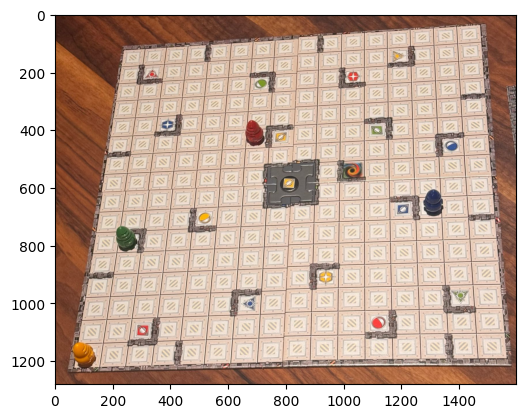

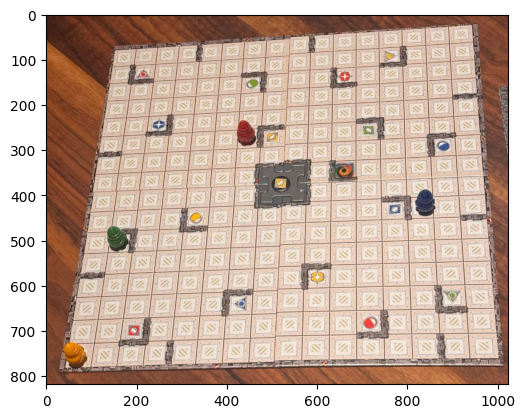

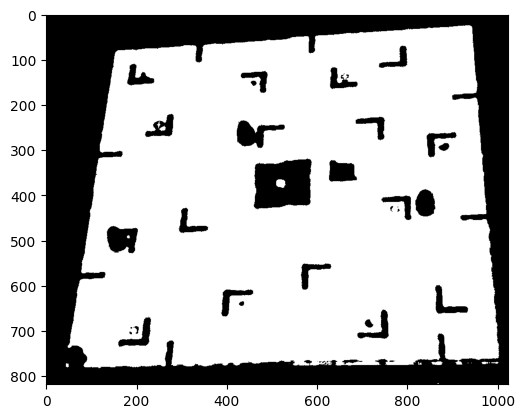

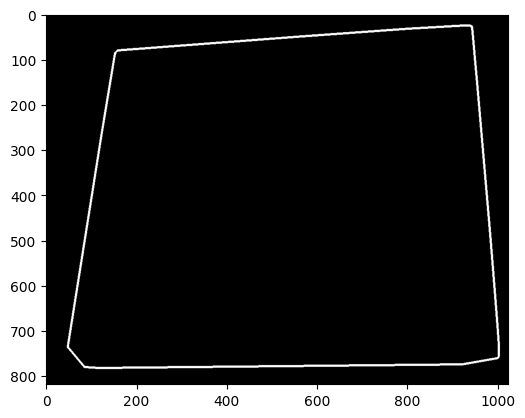

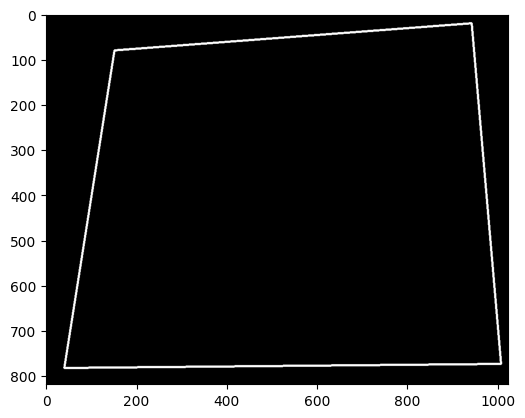

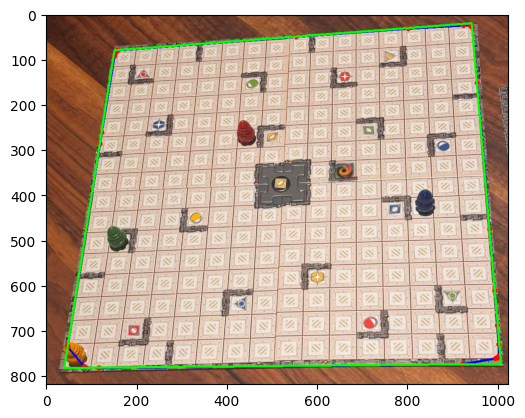

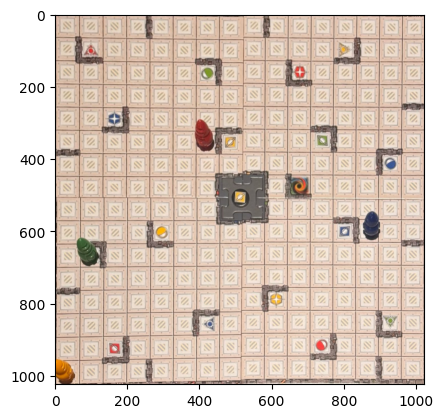

In [7]:
board_raw = cv2.imread("images/2.jpg")
quad, resized, width = get_bounding_quadrilateral(board_raw, do_plot=True)
board = unwarp_to_square(resized, quad, width)
patches = make_patches(board, 16, 16, 16)
patches_center = make_patches_center(board, 16, 16, 16)
plot(board)

In [8]:
# Robot position computation.
red_lower1 = np.array([0, 120, 70])
red_upper1 = np.array([10, 255, 255])

red_lower2 = np.array([170, 120, 70])
red_upper2 = np.array([180, 255, 255])

blue_lower = np.array([100, 0, 0])
blue_upper = np.array([140, 255, 255])

green_lower = np.array([40, 50, 50])
green_upper = np.array([90, 255, 255])

yellow_lower = np.array([20, 100, 100])
yellow_upper = np.array([40, 255, 255])

lower_gray = np.array([0, 0, 0])
upper_gray = np.array([0, 0, 255])


def mask_red(image):
    mask_red1 = cv2.inRange(image, red_lower1, red_upper1)
    mask_red2 = cv2.inRange(image, red_lower2, red_upper2)
    return cv2.bitwise_or(mask_red1, mask_red2)


mask_blue = lambda image: cv2.inRange(image, blue_lower, blue_upper)
mask_green = lambda image: cv2.inRange(image, green_lower, green_upper)
mask_yellow = lambda image: cv2.inRange(image, yellow_lower, yellow_upper)
mask_gray = lambda image: cv2.inRange(image, lower_gray, upper_gray)


def get_best_cell_for_mask(patches, mask):
    def apply_mask(cell):
        patch = cv2.cvtColor(patches[cell][0], cv2.COLOR_BGR2HSV)
        in_range = mask(patch)
        return np.count_nonzero(in_range) / np.prod(in_range.shape)

    best_cell = sorted(patches.keys(), key=apply_mask, reverse=True)[0]
    return best_cell


def may_likely_contain_robot(patch, area_threshold):
    blur = cv2.blur(patch, (5, 5))
    gray = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    return np.count_nonzero(thresh) > area_threshold * np.prod(thresh.shape)


def get_likely_robot_patches(patches):
    result = {}
    for r, c in patches:
        if 7 <= r < 9 and 7 <= c < 9:
            continue
        if may_likely_contain_robot(patches[r, c][0], 0.4):
            result[r, c] = patches[r, c]
    return result


def get_robot_positions(patches):
    color_masks = {"R": mask_red, "B": mask_blue, "Y": mask_yellow, "G": mask_green}
    likely_patches = get_likely_robot_patches(patches)
    result = {}
    for key in color_masks:
        mask = color_masks[key]
        result[key] = get_best_cell_for_mask(likely_patches, mask)
    return result

In [9]:
positions = get_robot_positions(patches)
for key in positions:
    print(key, positions[key])
    # plot(patches[positions[key]][0])

R (5, 6)
B (9, 13)
Y (15, 0)
G (10, 1)


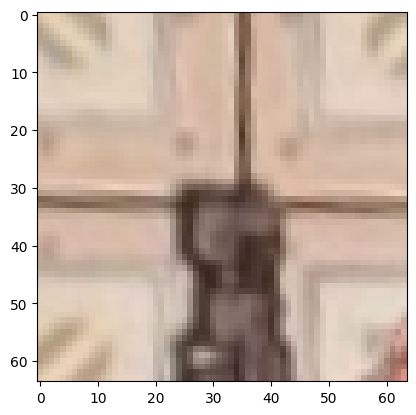

Largest Score: 0.6277398189847626
Center Type: b


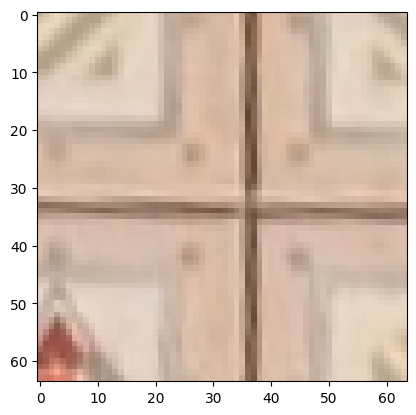

Largest Score: 0.6405935169443017
Center Type: empty


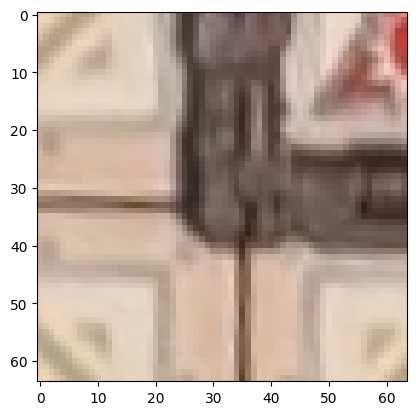

Largest Score: 0.6731786122198483
Center Type: ur


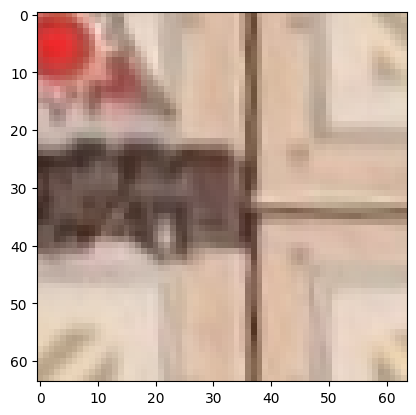

Largest Score: 0.4886936012622952
Center Type: ul


In [10]:
def quick_thresh(image):
    blur = cv2.bilateralFilter(image, 3, 5, 5)
    gray = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)
    return cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]


# Also tried just using a Frobenius norm...
def ssim(x, y):
    x_gray = quick_thresh(x)
    y_gray = quick_thresh(y)
    score, _ = structural_similarity(x_gray, y_gray, full=True)
    return score


def hamming(x, y):
    x_rgb = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    y_rgb = cv2.cvtColor(y, cv2.COLOR_BGR2RGB)
    return imagehash.average_hash(Image.fromarray(x_rgb)) - imagehash.average_hash(
        Image.fromarray(y_rgb)
    )


centers = {
    name: cv2.imread("images/" + name + ".jpg")
    for name in ["u", "l", "r", "b", "ul", "ur", "bl", "br", "empty"]
}
for r in range(2):
    for c in range(2):
        patch = patches_center[r, c][0]
        plot(patch)
        best_score = float("-inf")
        best_key = None
        for name in centers:
            score = ssim(patch, centers[name])
            if score > best_score:
                best_score = score
                best_key = name
        print("Largest Score:", best_score)
        print("Center Type:", best_key)